# Install Libraries

In [2]:
!pip3 install s3fs
%pip install --upgrade boto3


[notice] A new release of pip is available: 23.0.1 -> 23.1.2
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 23.0.1 -> 23.1.2
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


# Import Required Libraries

In [3]:
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score,confusion_matrix
from sklearn.metrics import roc_auc_score,roc_curve,f1_score
import matplotlib.pyplot as plt
from sklearn.feature_selection import SelectKBest,chi2 ## chi2 for classification problem

import seaborn as sns
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

import sagemaker
from sagemaker import get_execution_role

import boto3
from botocore.exceptions import ClientError

import json

import os
import time
from time import gmtime, strftime
import joblib
import subprocess

# Read data

In [4]:
# Read Data
x = pd.read_csv("x_one.csv")
y = pd.read_csv("y_one.csv")

# Merge them back 
x['response']=y

# Create df in case we need it
df = x.copy(deep=True)


x = x.dropna(axis=0, how='any')
y = x['response']
x = x.drop(['response'], axis=1)

# Prepare Train Test Sets

In [5]:
x_train,x_test,y_train,y_test=train_test_split(x,y,test_size=0.20)

# Define Endpoint Name

In [6]:
endpoint_name = 'cm-poc-salesforce'
EndpointName=endpoint_name

# Build and Test Model

### Logistic Regression

In [7]:
lg=LogisticRegression()
lg.fit(x_train,y_train)
print("Train Score: ", lg.score(x_train,y_train))
print("Test Score: ", lg.score(x_test,y_test))
lg_pred = lg.predict(x_test)
lg_pred_proba = lg.predict_proba(x_test)

print(f' logistic Accuracy {accuracy_score(lg_pred,y_test)}')
print(f' Roc Auc Score{roc_auc_score(lg_pred,y_test)}')

Train Score:  0.9789379256320517
Test Score:  0.9774599484510031
 logistic Accuracy 0.9774599484510031
 Roc Auc Score0.4888040841083704


### Decision Tree Classifier

In [8]:
dc=DecisionTreeClassifier(random_state=222,criterion='gini',min_samples_leaf=1)
dc.fit(x_train,y_train)
print("Train Score: ", dc.score(x_train,y_train))
print("Test Score: ", dc.score(x_test,y_test))
dc_pred = dc.predict(x_test)
dc_pred_proba = dc.predict_proba(x_test)

Train Score:  0.9991913780686571
Test Score:  0.9528983676151008


In [9]:
x_test_one=x_test.copy(deep=False)

x_test_one['pred']=dc_pred
predicted=x_test_one[x_test_one['pred']==1]
non_predict=x_test_one[x_test_one['pred']==0]

predicted.head(2)

print(dc.predict([[16200,2.0,2.0,2,232,31,25,331]]))
print(dc.predict([[5610,2.0,2.0,2,121,31,25,502]]))
print(dc.predict([[5610,2.0,2.0,2,121,31,25,502],[16200,2.0,2.0,2,232,31,25,331],[13200,2.0,2.0,2,232,31,25,3310]]))

predicted.to_csv('predicted.csv')

print(f' Decision Tree Accuracy: {accuracy_score(dc_pred,y_test)}')
print(f' Decision Tree f1_score: {f1_score(dc_pred,y_test)}')
print(f' Roc Auc Score{roc_auc_score(dc_pred,y_test)}')

tn, fp, fn, tp = confusion_matrix(y_test,dc_pred).ravel()
print("Confusion Matric Values (tn, fp, fn, tp): ", tn, fp, fn, tp)

'''
x = dc.predict([[5610,2.0,2.0,2,121,31,25,502],[16200,2.0,2.0,2,232,31,25,331],[13200,2.0,2.0,2,232,31,25,3310]]).tolist()
print(type(x))
print(x)
print(x.shape)
'''

[0]
[0]
[0 0 0]
 Decision Tree Accuracy: 0.9528983676151008
 Decision Tree f1_score: 0.05091649694501018
 Roc Auc Score0.5123328236304724
Confusion Matric Values (tn, fp, fn, tp):  18830 514 418 25


'\nx = dc.predict([[5610,2.0,2.0,2,121,31,25,502],[16200,2.0,2.0,2,232,31,25,331],[13200,2.0,2.0,2,232,31,25,3310]]).tolist()\nprint(type(x))\nprint(x)\nprint(x.shape)\n'

##### Accuracy Score is not the Model    ---   models=accuracy_score(dc_pred,y_test)

# Save Model Artifacts to S3

### We need to modify inference.py to match the input and output format of data expected for the model. See:  https://sagemaker.readthedocs.io/en/stable/frameworks/tensorflow/using_tf.html#id32

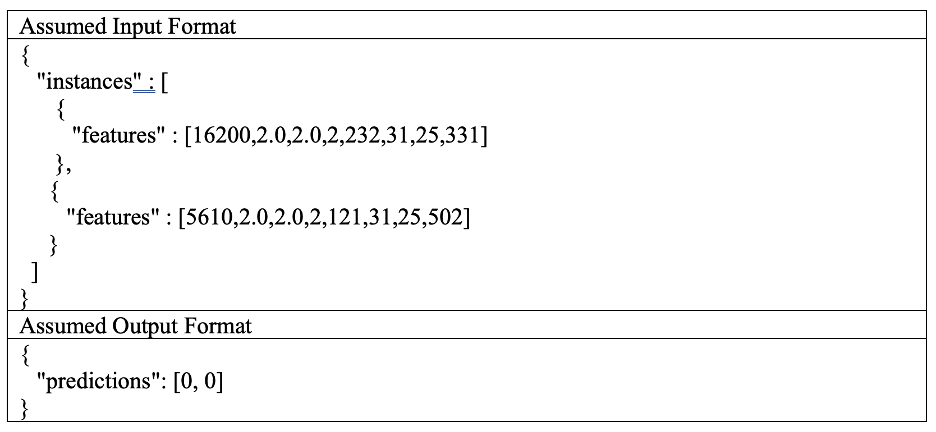

In [10]:
role = get_execution_role()
sagemaker_session = sagemaker.Session()
#Bucket for model artifacts 
bucket = sagemaker_session.default_bucket()
print(bucket)

session = boto3.session.Session()
s3 = session.resource('s3')
region_name = session.region_name

sagemaker_client = session.client(
    service_name='sagemaker',
    region_name=region_name
)

runtime_client = session.client(
    service_name ='sagemaker-runtime',
    region_name=region_name
)

###### Endpoint Prefix format should match the one in example below ######
project_name = "Customer_Response_Prediction"
end_point_prefix = "customer-response-prediction"

with open('model.joblib', 'wb') as f:
    joblib.dump(dc,f)

#Build tar file with model data + inference code 
bashCommand = "tar -cvpzf model.tar.gz model.joblib inference.py"
process = subprocess.Popen(bashCommand.split(), stdout=subprocess.PIPE)
output, error = process.communicate()

#Upload tar.gz to bucket
model_artifacts = f"s3://{bucket}/{project_name}/model.tar.gz"
s3.meta.client.upload_file('model.tar.gz', bucket, project_name+'/model.tar.gz')
print(model_artifacts)

sagemaker-us-east-1-768394235073
s3://sagemaker-us-east-1-768394235073/Customer_Response_Prediction/model.tar.gz


# Create Model

In [11]:
# retrieve sklearn image 
image_uri = sagemaker.image_uris.retrieve(
    framework="sklearn",
    region=region_name,
    version="1.0-1",
    py_version="py3",
    instance_type="ml.m5.xlarge",
)

#Create Model
model_name = end_point_prefix + "-" + strftime("%Y-%m-%d-%H-%M-%S", gmtime())
print("Model name: " + model_name)
create_model_response = sagemaker_client.create_model(
    ModelName=model_name,
    Containers=[
        {
            "Image": image_uri,
            "Mode": "SingleModel",
            "ModelDataUrl": model_artifacts,
            "Environment": {'SAGEMAKER_SUBMIT_DIRECTORY': model_artifacts,
                           'SAGEMAKER_PROGRAM': 'inference.py'} 
        }
    ],
    ExecutionRoleArn=role,
)
print("Model Arn: " + create_model_response["ModelArn"])


Model name: customer-response-prediction-2023-05-03-16-57-45
Model Arn: arn:aws:sagemaker:us-east-1:768394235073:model/customer-response-prediction-2023-05-03-16-57-45


# Create Endpoint

In [12]:
# Create Endpoint Configuration
sklearn_epc_name = end_point_prefix + "-" + strftime("%Y-%m-%d-%H-%M-%S", gmtime())
endpoint_config_response = sagemaker_client.create_endpoint_config(
    EndpointConfigName=sklearn_epc_name,
    ProductionVariants=[
        {
            "VariantName": "sklearnvariant",
            "ModelName": model_name,
            "InstanceType": "ml.c5.large",
            "InitialInstanceCount": 1
        },
    ],
)
print("Endpoint Configuration Arn: " + endpoint_config_response["EndpointConfigArn"])

# Create Endpoint
endpoint_name = end_point_prefix + strftime("%Y-%m-%d-%H-%M-%S", gmtime())
create_endpoint_response = sagemaker_client.create_endpoint(
    EndpointName=endpoint_name,
    EndpointConfigName=sklearn_epc_name,
)
print("Endpoint Arn: " + create_endpoint_response["EndpointArn"])

#Monitor creation
describe_endpoint_response = sagemaker_client.describe_endpoint(EndpointName=endpoint_name)
while describe_endpoint_response["EndpointStatus"] == "Creating":
    describe_endpoint_response = sagemaker_client.describe_endpoint(EndpointName=endpoint_name)
    print(describe_endpoint_response["EndpointStatus"])
    time.sleep(15)
print(describe_endpoint_response)

Endpoint Configuration Arn: arn:aws:sagemaker:us-east-1:768394235073:endpoint-config/customer-response-prediction-2023-05-03-16-57-45
Endpoint Arn: arn:aws:sagemaker:us-east-1:768394235073:endpoint/customer-response-prediction2023-05-03-16-57-46
Creating
Creating
Creating
Creating
Creating
Creating
Creating
Creating
Creating
Creating
InService
{'EndpointName': 'customer-response-prediction2023-05-03-16-57-46', 'EndpointArn': 'arn:aws:sagemaker:us-east-1:768394235073:endpoint/customer-response-prediction2023-05-03-16-57-46', 'EndpointConfigName': 'customer-response-prediction-2023-05-03-16-57-45', 'ProductionVariants': [{'VariantName': 'sklearnvariant', 'DeployedImages': [{'SpecifiedImage': '683313688378.dkr.ecr.us-east-1.amazonaws.com/sagemaker-scikit-learn:1.0-1-cpu-py3', 'ResolvedImage': '683313688378.dkr.ecr.us-east-1.amazonaws.com/sagemaker-scikit-learn@sha256:9dea8a5bb0ea9b48854d4b2b1f1d439e310718c29bea2fe76566a3e287c50de4', 'ResolutionTime': datetime.datetime(2023, 5, 3, 16, 57, 

# Test Endpoint

In [13]:

content_type = "application/json"
request_body = {
   "instances" : [ 
      {
         "features" : [16200,2.0,2.0,2,232,31,25,331]
      },
     {
        "features" : [5610,2.0,2.0,2,121,31,25,502]
     }
  ]
}

data = json.loads(json.dumps(request_body))
payload = json.dumps(data)
endpoint_name = describe_endpoint_response['EndpointName']

response = runtime_client.invoke_endpoint(
    EndpointName=endpoint_name,
    ContentType=content_type,
    Body=payload)
result = json.loads(response['Body'].read().decode())['predictions']
print(result)

[0, 0]


In [14]:
xxx

NameError: name 'xxx' is not defined

# Create API Gateway Using Cloudformation Template

In [49]:
#template_url = 'https://cf-templates-t63rjiazdc4e-us-east-1.s3.amazonaws.com/APIGateway_Lambda_ApiKey.yaml'
template_url = 'https://cf-templates-t63rjiazdc4e-us-east-1.s3.amazonaws.com/APIG_Lambda_ApiKey.yaml'

cf_client = boto3.client('cloudformation')
response = cf_client.create_stack(
    StackName=endpoint_name,
    TemplateURL= template_url,
    Parameters=[
        {
            'ParameterKey': 'endpointName',
            'ParameterValue': endpoint_name
        },
    ],
    DisableRollback=False,
    TimeoutInMinutes=10,
    Capabilities=[
        'CAPABILITY_NAMED_IAM'
    ],
    EnableTerminationProtection=False
)
print("API Gateway Creation Initiated")
response = ''
res = 'CREATE_IN_PROGRESS'
while res == 'CREATE_IN_PROGRESS':
    response = cf_client.describe_stacks(
    StackName=endpoint_name
    )
    res = response['Stacks'][0]['StackStatus']
    print("...")
    time.sleep(5)
print(response['Stacks'][0]['Outputs'])

API Gateway Creation Initiated
...
...
...
...
...
...
...
...
...
...
...
[{'OutputKey': 'ProdDataEndpoint', 'OutputValue': 'https://17li1fr2o7.execute-api.us-east-1.amazonaws.com/v1/', 'Description': 'API Prod stage endpoint'}]


In [ ]:
xxxxx

# Cleanup

In [ ]:
sagemaker_client.delete_endpoint(EndpointName=endpoint_name)
sagemaker_client.delete_endpoint_config(EndpointConfigName=sklearn_epc_name)
response = cf_client.delete_stack(StackName=endpoint_name)

# Curl Command for Testing API Gateway

In [50]:
command = f''' curl -i -H "x-api-key: vFExM5UNITfyzV6CECbKax3Br04OSR18OcTaNOQ7" -H "Content-Type: application/json" -X GET https://17li1fr2o7.execute-api.us-east-1.amazonaws.com/v1/CustomerResponse -d ''' + ''' ' {"instances" : [{"features" : [16200,2.0,2.0,2,232,31,25,331]},{"features" : [5610,2.0,2.0,2,121,31,25,502]}]}' '''
!{command}

HTTP/1.1 200 OK
Date: Wed, 03 May 2023 19:55:55 GMT
Content-Type: application/json
Content-Length: 21
Connection: close
x-amzn-RequestId: 49c07bf6-cc5c-418a-afd1-4b7b071f7016
x-amz-apigw-id: EXJbwH7BIAMFucQ=
X-Amzn-Trace-Id: Root=1-6452bc4a-158b0053419bda30036af028;Sampled=0

{"predictions":[0,0]}

In [ ]:
print(endpoint_name)

# Test Event

In [ ]:
'''
{
  "resource": "/hello",
  "path": "/hello",
  "httpMethod": "GET",
  "headers": {
    "Accept": "*/*",
    "Content-Type": "application/json",
    "Host": "kd41c641pj.execute-api.us-east-1.amazonaws.com",
    "User-Agent": "curl/7.68.0",
    "X-Amzn-Trace-Id": "Root=1-6451f8cd-13aeec971b77fa2b3625b65e",
    "x-api-key": "ikzPViwtQk6w1eZ0cL3FG8jWALYb0erU5T0t1xiP",
    "X-Forwarded-For": "52.4.240.77",
    "X-Forwarded-Port": "443",
    "X-Forwarded-Proto": "https"
  },
  "multiValueHeaders": {
    "Accept": [
      "*/*"
    ],
    "Content-Type": [
      "application/json"
    ],
    "Host": [
      "kd41c641pj.execute-api.us-east-1.amazonaws.com"
    ],
    "User-Agent": [
      "curl/7.68.0"
    ],
    "X-Amzn-Trace-Id": [
      "Root=1-6451f8cd-13aeec971b77fa2b3625b65e"
    ],
    "x-api-key": [
      "ikzPViwtQk6w1eZ0cL3FG8jWALYb0erU5T0t1xiP"
    ],
    "X-Forwarded-For": [
      "52.4.240.77"
    ],
    "X-Forwarded-Port": [
      "443"
    ],
    "X-Forwarded-Proto": [
      "https"
    ]
  },
  "queryStringParameters": null,
  "multiValueQueryStringParameters": null,
  "pathParameters": null,
  "stageVariables": null,
  "requestContext": {
    "resourceId": "iayvok",
    "resourcePath": "/hello",
    "operationName": "hello",
    "httpMethod": "GET",
    "extendedRequestId": "EVPQMEDDIAMFRXQ=",
    "requestTime": "03/May/2023:06:01:49 +0000",
    "path": "/v1/hello",
    "accountId": "768394235073",
    "protocol": "HTTP/1.1",
    "stage": "v1",
    "domainPrefix": "kd41c641pj",
    "requestTimeEpoch": 1683093709796,
    "requestId": "16c63c63-8658-40a7-8752-f99a004157fe",
    "identity": {
      "cognitoIdentityPoolId": null,
      "cognitoIdentityId": null,
      "apiKey": "ikzPViwtQk6w1eZ0cL3FG8jWALYb0erU5T0t1xiP",
      "principalOrgId": null,
      "cognitoAuthenticationType": null,
      "userArn": null,
      "apiKeyId": "3j8ze65on4",
      "userAgent": "curl/7.68.0",
      "accountId": null,
      "caller": null,
      "sourceIp": "52.4.240.77",
      "accessKey": null,
      "cognitoAuthenticationProvider": null,
      "user": null
    },
    "domainName": "kd41c641pj.execute-api.us-east-1.amazonaws.com",
    "apiId": "kd41c641pj"
  },
  "body": " {\"instances\" : [{\"features\" : [16200,2.0,2.0,2,232,31,25,331]},{\"features\" : [5610,2.0,2.0,2,121,31,25,502]}]}",
  "isBase64Encoded": false
}
'''

In [ ]:
command = f''' curl -i -H "x-api-key: {apig['key_value']}" -H "Content-Type: application/json" -X POST {apig['API_Gateway_URL']}/getInference -d ''' + ''' '{"Input": [["100.0000000000000000000"]]}' '''
!{command}

In [ ]:
import boto3
client=boto3.client('sagemaker-runtime')
response=client.invoke_endpoint(EndpointName='example-gus-test',Body=test_file.getvalue(),ContentType='text/csv')